### Dataset : Iris

In [3]:
from sklearn.datasets import load_iris #import load_iris function
from sklearn import metrics

iris=load_iris()
X=iris.data #features
y=iris.target #response

### Train Test Split (test size: 0.4)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=4)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90, 4)
(60, 4)
(90,)
(60,)


### Logistic Regresison

In [5]:
#train the model on the training set(Logistic Regression)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train) #train the model on the training set
y_pred=logreg.predict(X_test) #make predictions on the testing set
print(metrics.accuracy_score(y_test, y_pred)) #compare actual reponse values with predicted response values

0.9333333333333333


/Users/boyoonchoi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5) #repeat for KNN with K=5
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9666666666666667


In [7]:
knn=KNeighborsClassifier(n_neighbors=1) #repeat for KNN with K=1
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.95


### KNN: locating better value for K (trying K=1 through K=25 and recording testing accuracy)

Text(0, 0.5, 'Testing Accuracy')

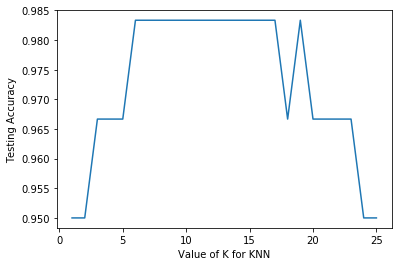

In [8]:
k_range=list(range(1,26)) #list containing integers from 1 to 25
scores=[] #empty list to store accuracy scores
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test,y_pred))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_range,scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Testing Accuracy")

* **Training accuracy** rises as model complexity increases.
* **Testing accuracy** penalizes models that are too complex or not complex enough.
* For KNN models, complexity is determined by the **value of K** (lower value = more complex).

#### making predictions on out-of-sample data

In [9]:
knn=KNeighborsClassifier(n_neighbors=11) #instantiate the model with the best known parameters
knn.fit(X,y) #not X_train, y_train
knn.predict([[3,5,4,2]])

array([1])

#### Downsides of train/test split?
* Provides a high-variance estimate of out-of-sample accuracy.
* K-fold cross validation overcomes this limitation.
* But, train/test split is still useful because of its flexibility and speed.

#### K_fold cross validation
1. Split the dataset into K equal **partitions**(or **"folds"**)
2. Use fold 1 as the testing set and the union of the other folds as the training set.
3. Calculate testing accuracy.
4. Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
5. Use **the average testing accuracy** as the estimate of out-of-sample accuracy.

#### Cross validation recommendations
* **K=10** is generally recommended.
* For classificaiton problems, **stratified sampling** is recommended for creating the folds.
    * each response class should be represented with equal proportions in each of the K folds.
    * scikit-learn's cross_val_score function does this by default.

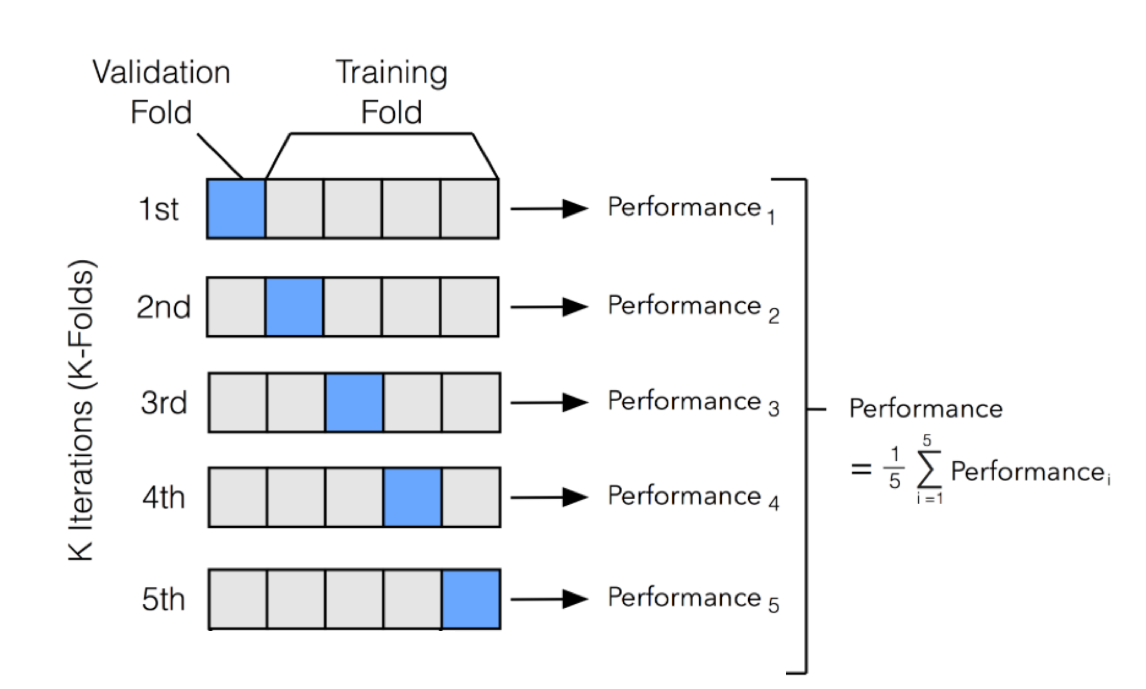

### KNN: Locating better value for K using K-Fold Cross Validation

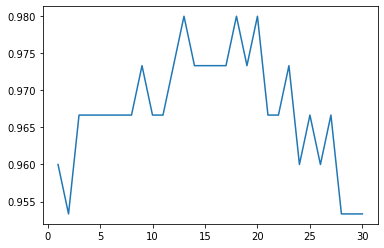

In [10]:
X=iris.data
y=iris.target

from sklearn.model_selection import cross_val_score
k_range=list(range(1,31))
k_scores=[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores)

### GridSearchCV: More efficient parameter tuning
* allows to define a grid of parameters that will be searched using K-fold cross-validation 

In [20]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
k_range=list(range(1,31))
weight_options=['uniform','distance']

#create a parameter grid: map the parameter names to the values that should be searched
param_grid=dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

#instantiate and fit the grid
grid=GridSearchCV(knn, param_grid, cv=10, scoring='accuracy') #K-fold cross-validation is used
grid.fit(X,y)
pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

print("\n* best accuracy score is : {}.".format(grid.best_score_))
print("* best parameters are : {}".format(grid.best_params_))
print("* best estimator is : {}".format(grid.best_estimator_))

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}

* best accuracy score is : 0.98.
* best parameters are : {'n_neighbors': 13, 'weights': 'uniform'}
* best estimator is : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')


In [22]:
#making predictions using the best parameters
knn=KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X,y)
knn.predict([[3,5,4,2]]) #make a prediction on out-of-sample data
print(knn.predict([[3,5,4,2]]))

#shortcut: GridSearchCV automatically refits the best model using all the data
grid.predict([[3,5,4,2]])
print(grid.predict([[3,5,4,2]]))

[1]
[1]


### RandomizedSearchCV
* searches **only a subset of the parameters**, so that you can control the computational "budget"
(searching many different parameters can be computationally infeasible)

In [23]:
from sklearn.model_selection import RandomizedSearchCV
#specify "parameter distributions" rather than a "parameter grid"
param_dist=dict(n_neighbors=k_range, weights=weight_options) 

#n_iter controls the number of searches
rand=RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5) 
rand.fit(X,y)
pd.DataFrame(rand.cv_results_)[['mean_test_score','std_test_score','params']]

,mean_test_score,std_test_score,params
0,0.973333,0.032660,"{'weights': 'distance', 'n_neighbors': 16}"
1,0.966667,0.033333,"{'weights': 'uniform', 'n_neighbors': 22}"
2,0.980000,0.030551,"{'weights': 'uniform', 'n_neighbors': 18}"
3,0.966667,0.044721,"{'weights': 'uniform', 'n_neighbors': 27}"
4,0.953333,0.042687,"{'weights': 'uniform', 'n_neighbors': 29}"
5,0.973333,0.032660,"{'weights': 'distance', 'n_neighbors': 10}"
6,0.966667,0.044721,"{'weights': 'distance', 'n_neighbors': 22}"
7,0.973333,0.044222,"{'weights': 'uniform', 'n_neighbors': 14}"
8,0.973333,0.044222,"{'weights': 'distance', 'n_neighbors': 12}"
9,0.973333,0.032660,"{'weights': 'uniform', 'n_neighbors': 15}"


In [24]:
print(rand.best_score_)
print(rand.best_params_)

0.98
{'weights': 'uniform', 'n_neighbors': 18}


* little experiment: is RandomizedSearchCV reliable enough?
* run RandomizedSearchCV 20 times and check the results -> all of them are close to the best score of GridSearchCV(0.98)

In [25]:
best_scores=[]
for _ in range(20):
    rand=RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X,y)
    best_scores.append(round(rand.best_score_,3))
print(best_scores)

[0.98, 0.98, 0.973, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.973, 0.973, 0.98, 0.98, 0.98, 0.98]
